In [17]:
from datasets import load_dataset

dataset = load_dataset("opus_books", "en-es")
full_dataset = dataset["train"]

# train, test, val splt instead of train val
split_1 = full_dataset.train_test_split(test_size=0.2, seed=42)
train_val = split_1["train"]
test_data = split_1["test"]

split_2 = train_val.train_test_split(test_size=0.1111, seed=42)  # 0.1111 of 0.9 ≈ 10%
train_data = split_2["train"]
val_data = split_2["test"]


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
from transformers import MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-en-es"
tokenizer = MarianTokenizer.from_pretrained(model_name)
max_length = 64

def preprocess(example):
    model_input = tokenizer(example["translation"]["en"], max_length=max_length, padding="max_length", truncation=True)
    labels = tokenizer(example["translation"]["es"], max_length=max_length, padding="max_length", truncation=True)
    model_input["labels"] = labels["input_ids"]
    return model_input

tokenized_train = train_data.map(preprocess, remove_columns=["id", "translation"])
tokenized_val = val_data.map(preprocess, remove_columns=["id", "translation"])
tokenized_test = test_data.map(preprocess, remove_columns=["id", "translation"])


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [19]:
import torch
from transformers import MarianMTModel

model = MarianMTModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [20]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

training_args = Seq2SeqTrainingArguments(
    output_dir="./opus_en_es_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    predict_with_generate=True,
    save_total_limit=1,
    report_to="none",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


lets get the bleu score before fine tuning

In [ ]:
from transformers import MarianMTModel, MarianTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from sacrebleu import corpus_bleu
import torch

# load the original pretrained model
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-es")
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

eval_args = Seq2SeqTrainingArguments(
    output_dir="./eval_untrained",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    report_to="none",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

eval_trainer = Seq2SeqTrainer(
    model=model,
    args=eval_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# compute validation BLEU
val_pred = eval_trainer.predict(tokenized_val)
val_preds = tokenizer.batch_decode(val_pred.predictions, skip_special_tokens=True)
val_labels = tokenizer.batch_decode(val_pred.label_ids, skip_special_tokens=True)
untrained_bleu = corpus_bleu(val_preds, [val_labels]).score

print(f"Validation BLEU (Before Fine-Tuning): {untrained_bleu:.2f}")


100%|██████████| 520/520 [15:25<00:00,  1.78s/it]


Validation BLEU (Before Fine-Tuning): 14.89


In [21]:
# from sacrebleu import corpus_bleu
# import time

# bleu_per_epoch = []
# epoch_times = []

# for epoch in range(2):
#     start = time.time()
#     trainer.train()
#     end = time.time()
#     epoch_times.append(end - start)

#     val_pred = trainer.predict(tokenized_val)
#     preds = tokenizer.batch_decode(val_pred.predictions, skip_special_tokens=True)
#     labels = tokenizer.batch_decode(val_pred.label_ids, skip_special_tokens=True)
#     bleu = corpus_bleu(preds, [labels]).score
#     bleu_per_epoch.append(bleu)
#     print(f"Epoch {epoch+1} BLEU: {bleu:.2f}, Time: {epoch_times[-1]:.2f} sec")


In [22]:
from sacrebleu import corpus_bleu
import time

bleu_per_epoch = []
epoch_times = []

for epoch in range(2):
    start = time.time()
    trainer.train()
    end = time.time()
    epoch_times.append(end - start)

    val_pred = trainer.predict(tokenized_val)
    preds = tokenizer.batch_decode(val_pred.predictions, skip_special_tokens=True)
    labels = tokenizer.batch_decode(val_pred.label_ids, skip_special_tokens=True)
    bleu = corpus_bleu(preds, [labels]).score
    bleu_per_epoch.append(bleu)
    print(f"Epoch {epoch+1} BLEU: {bleu:.2f}, Time: {epoch_times[-1]:.2f} sec")


  6%|▌         | 500/8310 [02:36<40:34,  3.21it/s]

{'loss': 1.9546, 'grad_norm': 3.3344943523406982, 'learning_rate': 1.8796630565583636e-05, 'epoch': 0.12}


 12%|█▏        | 1000/8310 [05:17<41:24,  2.94it/s]

{'loss': 1.5414, 'grad_norm': 3.0614891052246094, 'learning_rate': 1.759326113116727e-05, 'epoch': 0.24}


 18%|█▊        | 1500/8310 [07:53<34:43,  3.27it/s]

{'loss': 1.3842, 'grad_norm': 3.026151418685913, 'learning_rate': 1.6389891696750904e-05, 'epoch': 0.36}


 24%|██▍       | 2000/8310 [10:26<31:27,  3.34it/s]

{'loss': 1.3138, 'grad_norm': 2.9586987495422363, 'learning_rate': 1.5186522262334538e-05, 'epoch': 0.48}


 30%|███       | 2500/8310 [12:58<29:14,  3.31it/s]

{'loss': 1.2795, 'grad_norm': 3.173635244369507, 'learning_rate': 1.3983152827918172e-05, 'epoch': 0.6}


 36%|███▌      | 3000/8310 [15:30<26:13,  3.37it/s]

{'loss': 1.2445, 'grad_norm': 2.339324474334717, 'learning_rate': 1.2779783393501806e-05, 'epoch': 0.72}


 42%|████▏     | 3500/8310 [18:07<25:07,  3.19it/s]

{'loss': 1.2, 'grad_norm': 2.9053025245666504, 'learning_rate': 1.157641395908544e-05, 'epoch': 0.84}


 48%|████▊     | 4000/8310 [20:45<22:30,  3.19it/s]

{'loss': 1.191, 'grad_norm': 2.8411779403686523, 'learning_rate': 1.0373044524669073e-05, 'epoch': 0.96}


                                                   
 50%|█████     | 4155/8310 [22:15<18:32,  3.73it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}


{'eval_loss': 1.087510108947754, 'eval_runtime': 40.8767, 'eval_samples_per_second': 203.245, 'eval_steps_per_second': 12.721, 'epoch': 1.0}


 54%|█████▍    | 4500/8310 [24:19<23:18,  2.72it/s]   

{'loss': 1.1384, 'grad_norm': 2.6342103481292725, 'learning_rate': 9.169675090252709e-06, 'epoch': 1.08}


 60%|██████    | 5000/8310 [27:01<17:27,  3.16it/s]

{'loss': 1.1069, 'grad_norm': 2.899354934692383, 'learning_rate': 7.966305655836343e-06, 'epoch': 1.2}


 66%|██████▌   | 5500/8310 [29:39<14:47,  3.17it/s]

{'loss': 1.1124, 'grad_norm': 2.6256935596466064, 'learning_rate': 6.762936221419977e-06, 'epoch': 1.32}


 72%|███████▏  | 6000/8310 [32:17<12:05,  3.18it/s]

{'loss': 1.0956, 'grad_norm': 2.708740234375, 'learning_rate': 5.559566787003611e-06, 'epoch': 1.44}


 78%|███████▊  | 6500/8310 [34:54<09:30,  3.17it/s]

{'loss': 1.0891, 'grad_norm': 2.4286556243896484, 'learning_rate': 4.356197352587245e-06, 'epoch': 1.56}


 84%|████████▍ | 7000/8310 [37:31<06:57,  3.14it/s]

{'loss': 1.0679, 'grad_norm': 2.5545167922973633, 'learning_rate': 3.1528279181708787e-06, 'epoch': 1.68}


 90%|█████████ | 7500/8310 [40:09<04:18,  3.13it/s]

{'loss': 1.068, 'grad_norm': 2.8705058097839355, 'learning_rate': 1.949458483754513e-06, 'epoch': 1.81}


 96%|█████████▋| 8000/8310 [42:47<01:38,  3.14it/s]

{'loss': 1.0723, 'grad_norm': 3.0169715881347656, 'learning_rate': 7.460890493381469e-07, 'epoch': 1.93}


                                                   
100%|██████████| 8310/8310 [45:06<00:00,  3.78it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}


{'eval_loss': 1.0320098400115967, 'eval_runtime': 40.6785, 'eval_samples_per_second': 204.236, 'eval_steps_per_second': 12.783, 'epoch': 2.0}


100%|██████████| 8310/8310 [45:07<00:00,  3.07it/s]


{'train_runtime': 2707.3978, 'train_samples_per_second': 49.101, 'train_steps_per_second': 3.069, 'train_loss': 1.2348445520504288, 'epoch': 2.0}


100%|██████████| 520/520 [16:15<00:00,  1.88s/it]


Epoch 1 BLEU: 18.42, Time: 2708.17 sec


  6%|▌         | 500/8310 [02:39<40:44,  3.19it/s]

{'loss': 1.0691, 'grad_norm': 2.739985227584839, 'learning_rate': 1.8796630565583636e-05, 'epoch': 0.12}


 12%|█▏        | 1000/8310 [05:18<38:39,  3.15it/s]

{'loss': 1.0548, 'grad_norm': 2.5639476776123047, 'learning_rate': 1.759326113116727e-05, 'epoch': 0.24}


 18%|█▊        | 1500/8310 [07:59<36:30,  3.11it/s]

{'loss': 1.0204, 'grad_norm': 2.5145175457000732, 'learning_rate': 1.6389891696750904e-05, 'epoch': 0.36}


 21%|██        | 1754/8310 [09:20<36:16,  3.01it/s]

KeyboardInterrupt: 

interrupted due to time constraint subject to submission deadline and slow training

thus bleu score after epoch 1 is 18.42

In [23]:
from transformers import MarianMTModel, MarianTokenizer

model = MarianMTModel.from_pretrained("./final_opus_model")
tokenizer = MarianTokenizer.from_pretrained("./final_opus_model")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [24]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./dummy_eval_output",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    report_to="none",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


In [25]:
# Validation BLEU
val_pred = trainer.predict(tokenized_val)
val_preds = tokenizer.batch_decode(val_pred.predictions, skip_special_tokens=True)
val_labels = tokenizer.batch_decode(val_pred.label_ids, skip_special_tokens=True)
val_bleu = corpus_bleu(val_preds, [val_labels]).score
print("Validation BLEU:", val_bleu)

# Test BLEU
test_pred = trainer.predict(tokenized_test)
test_preds = tokenizer.batch_decode(test_pred.predictions, skip_special_tokens=True)
test_labels = tokenizer.batch_decode(test_pred.label_ids, skip_special_tokens=True)
test_bleu = corpus_bleu(test_preds, [test_labels]).score
print(f"Final Test BLEU Score: {test_bleu:.2f}")


100%|██████████| 520/520 [16:35<00:00,  1.91s/it]


Validation BLEU: 19.189774745016113


100%|██████████| 1169/1169 [36:13<00:00,  1.86s/it]


Final Test BLEU Score: 19.55


before training

In [26]:
from transformers import MarianMTModel, MarianTokenizer

# Load pre-trained (unfine-tuned) model
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-es")
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")

model = model.to("cuda" if torch.cuda.is_available() else "cpu")


# PLOTS

NOTE: 

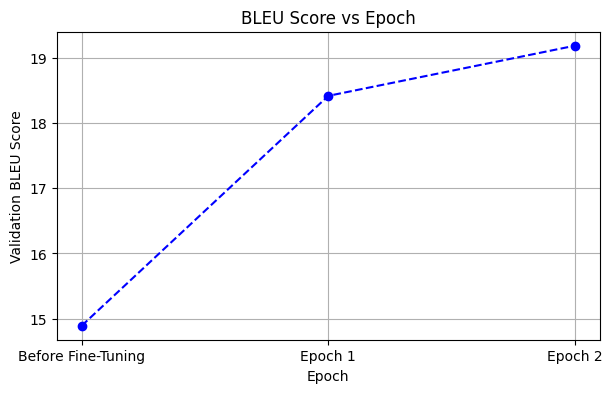

In [29]:
import matplotlib.pyplot as plt

# BLEU scores
bleu_scores = [14.89, 18.42, 19.19]
epochs = [0, 1, 2]
labels = ["Before Fine-Tuning", "Epoch 1", "Epoch 2"]

plt.figure(figsize=(7, 4))
plt.plot(epochs, bleu_scores, marker="o", linestyle="--", color="blue")
plt.xticks(epochs, labels)
plt.xlabel("Epoch")
plt.ylabel("Validation BLEU Score")
plt.title("BLEU Score vs Epoch")
plt.grid()
plt.show()


In [32]:
logs = [
    {'loss': 1.9546, 'epoch': 0.12},
    {'loss': 1.5414, 'epoch': 0.24},
    {'loss': 1.3842, 'epoch': 0.36},
    {'loss': 1.3138, 'epoch': 0.48},
    {'loss': 1.2795, 'epoch': 0.60},
    {'loss': 1.2445, 'epoch': 0.72},
    {'loss': 1.2000, 'epoch': 0.84},
    {'loss': 1.1910, 'epoch': 0.96},
    {'loss': 1.1384, 'epoch': 1.08},
    {'loss': 1.1069, 'epoch': 1.20},
    {'loss': 1.1124, 'epoch': 1.32},
    {'loss': 1.0956, 'epoch': 1.44},
    {'loss': 1.0891, 'epoch': 1.56},
    {'loss': 1.0679, 'epoch': 1.68},
    {'loss': 1.0680, 'epoch': 1.81},
    {'loss': 1.0723, 'epoch': 1.93}
]
# these logs are taken from the training logs of the model, showing the loss at different epochs 
# i am plotting manually because the model did not save the logs during training

In [ ]:
#had to extract log text from output of training cell as logs were not saved
log_text = """
{'loss': 1.9546, 'grad_norm': 3.3344943523406982, 'learning_rate': 1.8796630565583636e-05, 'epoch': 0.12}
{'loss': 1.5414, 'grad_norm': 3.0614891052246094, 'learning_rate': 1.759326113116727e-05, 'epoch': 0.24}
{'loss': 1.3842, 'grad_norm': 3.026151418685913, 'learning_rate': 1.6389891696750904e-05, 'epoch': 0.36}
{'loss': 1.3138, 'grad_norm': 2.9586987495422363, 'learning_rate': 1.5186522262334538e-05, 'epoch': 0.48}
{'loss': 1.2795, 'grad_norm': 3.173635244369507, 'learning_rate': 1.3983152827918172e-05, 'epoch': 0.6}
{'loss': 1.2445, 'grad_norm': 2.339324474334717, 'learning_rate': 1.2779783393501806e-05, 'epoch': 0.72}
{'loss': 1.2, 'grad_norm': 2.9053025245666504, 'learning_rate': 1.157641395908544e-05, 'epoch': 0.84}
{'loss': 1.191, 'grad_norm': 2.8411779403686523, 'learning_rate': 1.0373044524669073e-05, 'epoch': 0.96}
{'eval_loss': 1.087510108947754, 'epoch': 1.0}
{'loss': 1.1384, 'grad_norm': 2.6342103481292725, 'learning_rate': 9.169675090252709e-06, 'epoch': 1.08}
{'loss': 1.1069, 'grad_norm': 2.899354934692383, 'learning_rate': 7.966305655836343e-06, 'epoch': 1.2}
{'loss': 1.1124, 'grad_norm': 2.6256935596466064, 'learning_rate': 6.762936221419977e-06, 'epoch': 1.32}
{'loss': 1.0956, 'grad_norm': 2.708740234375, 'learning_rate': 5.559566787003611e-06, 'epoch': 1.44}
{'loss': 1.0891, 'grad_norm': 2.4286556243896484, 'learning_rate': 4.356197352587245e-06, 'epoch': 1.56}
{'loss': 1.0679, 'grad_norm': 2.5545167922973633, 'learning_rate': 3.1528279181708787e-06, 'epoch': 1.68}
{'loss': 1.068, 'grad_norm': 2.8705058097839355, 'learning_rate': 1.949458483754513e-06, 'epoch': 1.81}
{'loss': 1.0723, 'grad_norm': 3.0169715881347656, 'learning_rate': 7.460890493381469e-07, 'epoch': 1.93}
{'eval_loss': 1.0320098400115967, 'epoch': 2.0}
"""


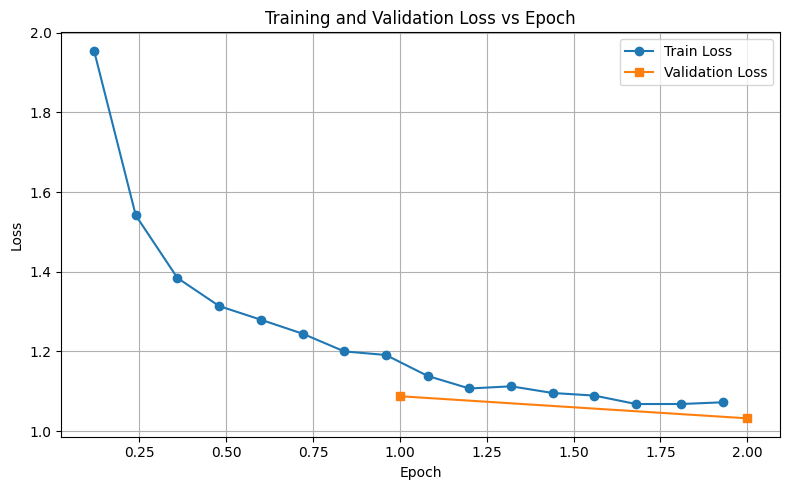

In [42]:
import ast
import matplotlib.pyplot as plt

# Parse each dictionary from the log
lines = [line.strip() for line in log_text.strip().split("\n") if line.strip()]
logs = [ast.literal_eval(line) for line in lines]

# Separate train and eval logs
train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []

for log in logs:
    if "loss" in log and "eval_loss" not in log:
        train_epochs.append(log["epoch"])
        train_losses.append(log["loss"])
    elif "eval_loss" in log:
        eval_epochs.append(log["epoch"])
        eval_losses.append(log["eval_loss"])

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_epochs, train_losses, label="Train Loss", marker='o')
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


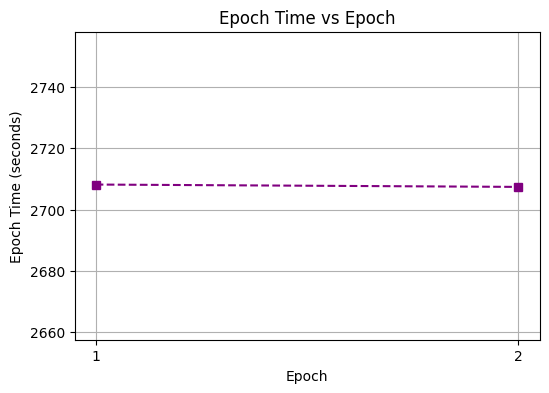

In [35]:
import matplotlib.pyplot as plt

epochs = [1, 2]
epoch_times = [2708.17, 2707.40]

plt.figure(figsize=(6, 4))
plt.plot(epochs, epoch_times, marker='s', linestyle='--', color='purple')
plt.xlabel("Epoch")
plt.ylabel("Epoch Time (seconds)")
plt.title("Epoch Time vs Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.ylim(min(epoch_times) - 50, max(epoch_times) + 50)
plt.show()


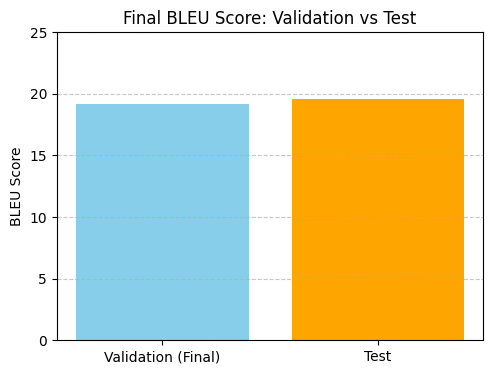

In [37]:
import matplotlib.pyplot as plt

# Final BLEU scores after training (you already obtained these)
val_bleu = 19.19
test_bleu = 19.55

# Plot
plt.figure(figsize=(5.5, 4))
plt.bar(["Validation (Final)", "Test"], [val_bleu, test_bleu], color=["skyblue", "orange"])
plt.ylabel("BLEU Score")
plt.title("Final BLEU Score: Validation vs Test")
plt.ylim(0, 25)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
trainer.save_model("./final_opus_model")  # Saves the model weights and config
tokenizer.save_pretrained("./final_opus_model")  # Saves the tokenizer config/vocab


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}


('./final_opus_model\\tokenizer_config.json',
 './final_opus_model\\special_tokens_map.json',
 './final_opus_model\\vocab.json',
 './final_opus_model\\source.spm',
 './final_opus_model\\target.spm',
 './final_opus_model\\added_tokens.json')